# Religious Migration Analysis 1990-2020
Author: add later\
Data Source: Pew Research Center (https://www.pewresearch.org/dataset/dataset-religious-composition-of-the-worlds-migrants-1990-2020/)

This analysis explores global religious migration patterns from 1990-2020, examining how migration flows have influenced religious demographics across different geographical scales.

Dataset Structure:
- 26712 rows
- 9 columns
- Hierarchical data (Country -> Regional -> Global levels)
- Time period: 1990-2020 (5-year intervals)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
migration = pd.read_csv('data/Incoming_and_Outgoing_Migrant_Counts.csv', thousands=',')
migration.head(5)

,Direction,Year,Country,Religion,Count,Percent,Region,level,countrycode
0,Incoming,1990,Global Total,All,"152,970,000",100.0,Global,3,9999
1,Incoming,1990,Global Total,Buddhist,"4,590,000",3.0,Global,3,9999
2,Incoming,1990,Global Total,Christian,"72,710,000",47.5,Global,3,9999
3,Incoming,1990,Global Total,Hindu,"9,130,000",6.0,Global,3,9999
4,Incoming,1990,Global Total,Jew,"2,340,000",1.5,Global,3,9999


## Function definitions

In [5]:
def explore_data_quality(df):
    """
    Perform initial data quality checks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to analyze
        
    Returns:
    --------
    dict
        Dictionary containing data quality metrics
    """
    quality_report = {
        'missing_values': df.isnull().sum(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
        'data_types': df.dtypes
    }
    return quality_report

def format_numbers(ax):
    """
    Format y-axis numbers to use comma separators instead of scientific notation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to format
        
    Returns
    -------
    None
        Modifies the axis object in place

    Example
    -------
    >>> fig, ax = plt.subplots()
    >>> plot_data(ax)
    >>> format_numbers(ax)
    """
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

def make_autopct(values):
    """
    Creates a function to format percentage labels for pie charts.
    Only shows labels for segments larger than 5% of the total.
    
    Parameters:
    ----------
    values : array-like
        The values used to generate the pie chart
        
    Returns:
    -------
    function
        A function that takes a percentage value and returns:
        - Formatted percentage string (e.g., "25%") for values > 5%
        - Empty string for values ≤ 5%
        
    Example:
    -------
    >>> values = [30, 45, 15, 10]
    >>> plt.pie(values, autopct=make_autopct(values))
    """
    def my_autopct(pct):
        return f'{pct:.0f}%' if pct > 5 else ''  # only show if >5%
    return my_autopct

## Cleaning the data

In [7]:
explore_data_quality(migration)

{'missing_values': Direction      0
 Year           0
 Country        0
 Religion       0
 Count          0
 Percent        0
 Region         0
 level          0
 countrycode    0
 dtype: int64,
 'unique_values': {'Direction': 2,
  'Year': 7,
  'Country': 239,
  'Religion': 8,
  'Count': 834,
  'Percent': 955,
  'Region': 7,
  'level': 3,
  'countrycode': 239},
 'data_types': Direction       object
 Year             int64
 Country         object
 Religion        object
 Count           object
 Percent        float64
 Region          object
 level            int64
 countrycode      int64
 dtype: object}

In [8]:
#Changing the following column type to 'category' for memory optimization: Direction, Religion, Region, Level 
migration = migration.astype({
    'Direction': 'category',
    'Religion': 'category',
    'Region': 'category',
    'level': 'category',
})

#Standardized column names to lowercase
migration.columns = migration.columns.str.lower()

#Replacing values of '< 10,000' with 5,000 for numerical calculations. The number 5000 was chosen as a midpoint since we don't have the actual numbers
migration['count'] = migration['count'].replace('< 10,000', '5000')

#Remove commas and convert 'count' to numbers
migration['count'] = migration['count'].str.replace(',', '')
migration['count'] = pd.to_numeric(migration['count'])

## Global Migration

### Data Prep for Global Analysis

In [11]:
# Global Migration Trends 1990 to 2020
global_level_df = migration[(migration['level'] == 3) & # filter for global level data
                          (migration['religion'] != 'All') & # remove 'All' value. 'All' rows total every religion
                          (migration['direction'] == 'Incoming')].copy() #Filter for only 'Incoming' to avoid doubling the actual number of migrants
global_level_df['religion'] = global_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts
order = global_level_df.groupby('religion', observed=True)['count'].mean().sort_values(ascending=False).index # Storing sort order in variable for barplot

# Migration Growth Rates by Religious Group 1990-2020
global_growth_df = global_level_df.pivot_table(index='religion', columns='year', values='count') #Pivot the dataframe with years as column, migration count as values and religion as index
global_growth_df['growthrate'] = (global_growth_df[2020] - global_growth_df[1990]) / global_growth_df[1990] * 100 #Add growth rate column
global_growth_df['abs_diff'] = global_growth_df[2020] - global_growth_df[1990] # Add an absolute difference column

# Global Migration Growth Rates by Religious Group Before and After 2005
growth_periods_df = global_growth_df.copy()
growth_periods_df['post_2005'] = round((growth_periods_df[2020] - growth_periods_df[2005]) / growth_periods_df[2005] * 100)
growth_periods_df['pre_2005'] = round((growth_periods_df[2005] - growth_periods_df[1990]) / growth_periods_df[1990] * 100)
growth_periods_df.reset_index(inplace=True)
growth_periods_df = pd.melt(growth_periods_df, 
                           id_vars=['religion'], 
                           value_vars=['pre_2005', 'post_2005'], 
                           var_name='period', 
                           value_name='growth rate')

#### Global migration patterns show steady growth from 1990 to 2020, with a notable acceleration after 2005. During this period, both the volume and composition of religious migration underwent significant changes...

**Key Findings**:
- Global migration increased 83.4% from 1990 to 2020.
- Christians and Muslims consistently represent the largest migration groups.
- Despite smaller total numbers, Buddhist migration showed the highest growth rate of 137%.
- Muslims had the largest migration growth rate post-2005.
- Buddhists were the only group to see a decline in migration growth post-2005.
- Jewish migration remains generally low, indicating some level of stability.

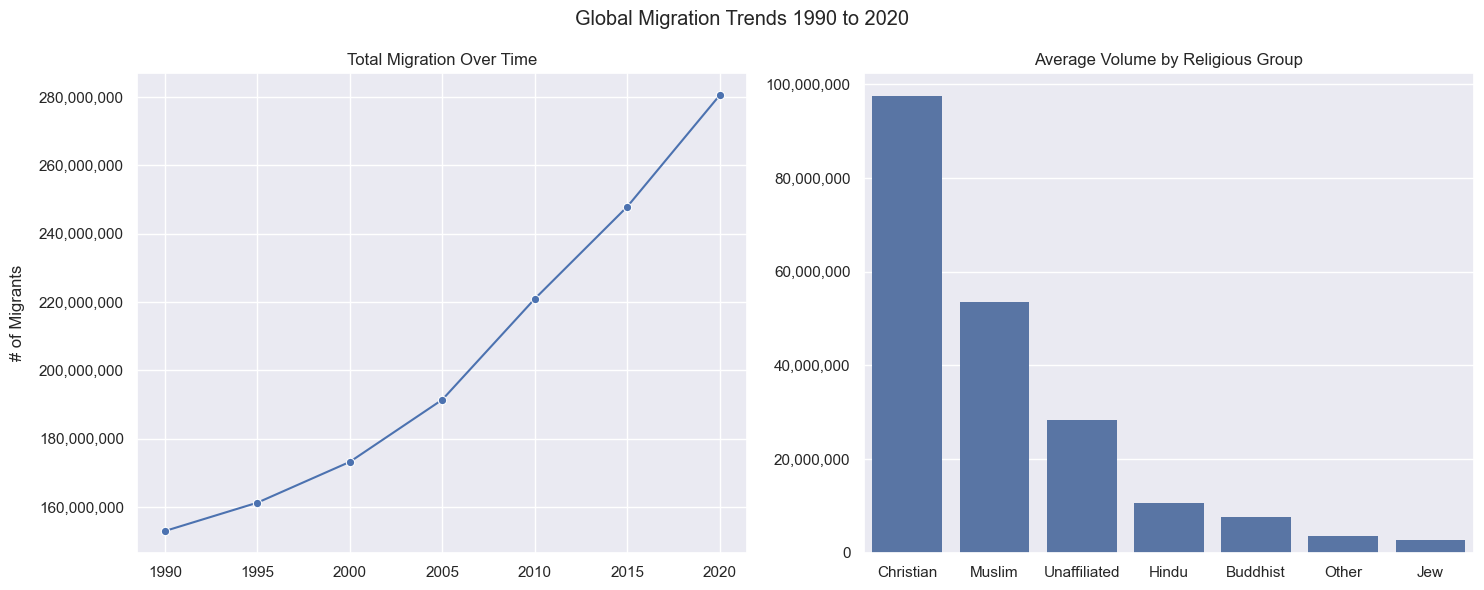

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=global_level_df, 
             x='year', y='count', 
             errorbar=None, marker='o', 
             estimator=sum, ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('# of Migrants', labelpad=10)
ax1.set_xlabel('')
ax1.set_title('Total Migration Over Time')

sns.barplot(data = global_level_df, 
            x='religion', y='count', 
            errorbar=None, order=order, 
            linewidth=0, ax=ax2)
format_numbers(ax2)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Average Volume by Religious Group')

plt.suptitle('Global Migration Trends 1990 to 2020')
plt.tight_layout()

Global migration has consistently increased with an inflection point after 2005. Christians have the highest amounts of migration on average, followed by Muslims and the religiously unaffiliated.

### Global Growth Rates
How have growth rates changed?

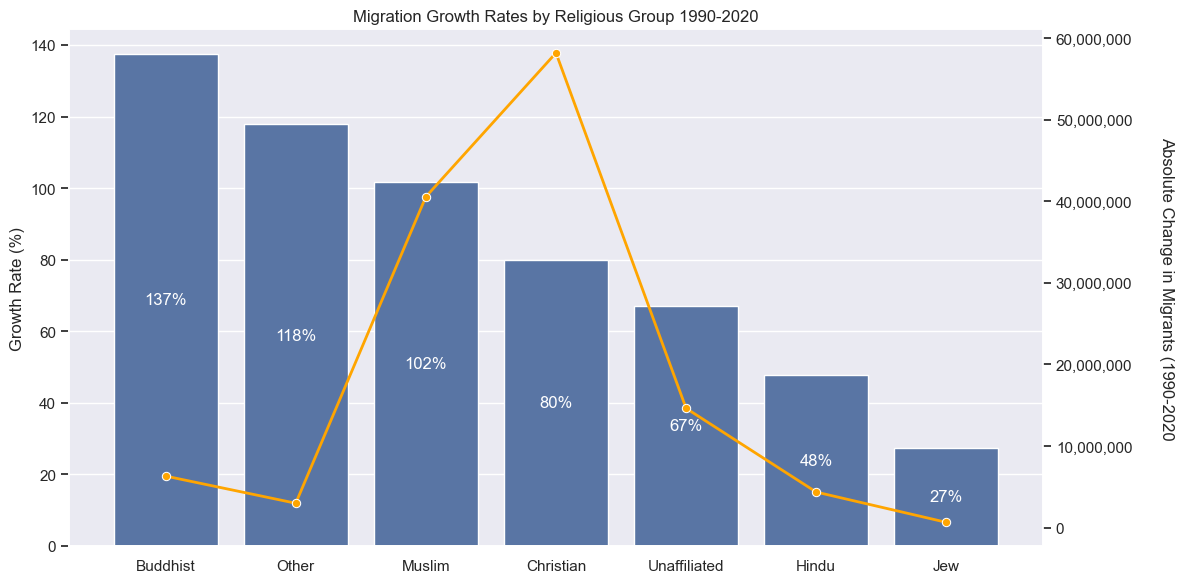

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(data=global_growth_df, 
            x='religion', y='growthrate',
           order=global_growth_df.sort_values('growthrate', ascending=False).index,
           ax=ax1)

ax1.set_xlabel('')
ax1.set_ylabel('Growth Rate (%)')
ax1.bar_label(ax1.containers[0], label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

ax2 = ax1.twinx()
sns.lineplot(data=global_growth_df,
             x='religion', y='abs_diff',
             ax=ax2, color='orange',
             linewidth=2, marker='o')

format_numbers(ax2)
ax2.set_ylabel('Absolute Change in Migrants (1990-2020', labelpad=30, rotation=270)
ax2.grid(alpha=0)


plt.title('Migration Growth Rates by Religious Group 1990-2020')
plt.tight_layout()

Despite having smaller overall numbers of change, Buddhists represent the highest growth percentage of all religious groups. Christians, having the highest migration numbers, fall to the middle of the pack with around 80% growth, still a relatively high numbers.

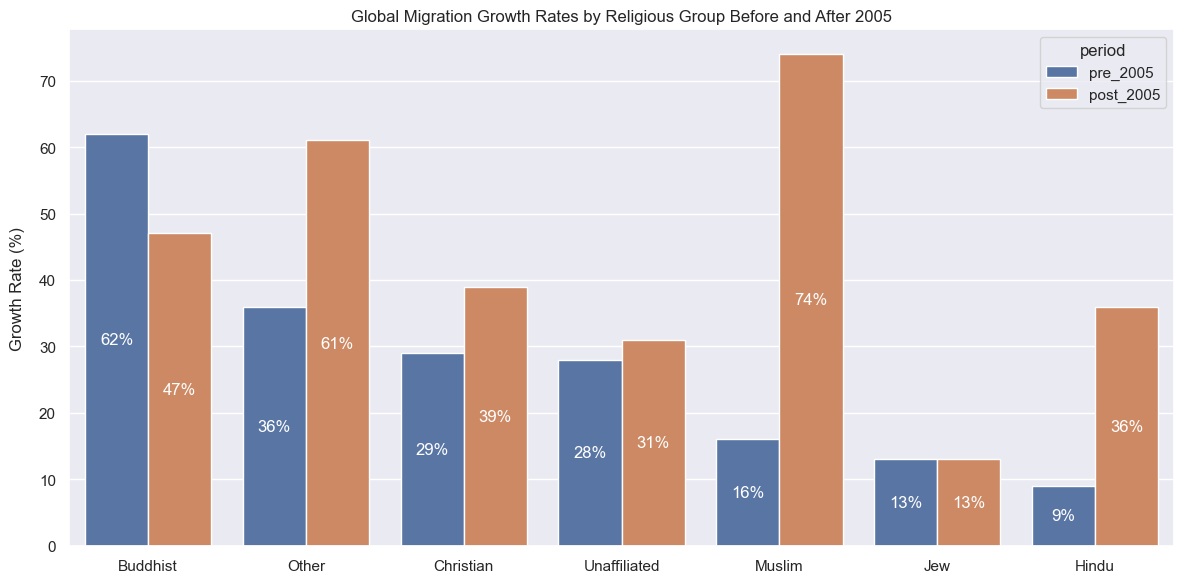

In [18]:
plt.figure(figsize=(12, 6))

order = growth_periods_df[growth_periods_df['period'] == 'pre_2005'].sort_values('growth rate', ascending=False)['religion']

ax = sns.barplot(growth_periods_df, 
                 x='religion', y='growth rate', 
                 hue='period', order=order)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

plt.xlabel('')
plt.ylabel('Growth Rate (%)', labelpad=10)
plt.title('Global Migration Growth Rates by Religious Group Before and After 2005')
plt.tight_layout()

Muslims represent the largest growth post-2005. Interestingly, most groups showed post 2005 increases except for Buddhists, who's growth slightly declined.

#### These global patterns, however, mask significant regional variations in both the volume and religious composition of migration flows...

# Regional Breakdown

### Data Prep for Regional Analysis

In [23]:
# Regional Migration Patterns 1990-2020
region_level_df = migration[migration['level'] == 2].copy()
region_level_df['region'] = region_level_df['region'].cat.remove_categories(['Global'])

# Overall Net Migration by Region 1990-2020
pivoted_region_level = region_level_df.pivot_table(
    values='count', 
    columns='direction', 
    index='region').astype('int') #pivoting region_level_df to focus on incoming vs outgoing by region
net_diff = pivoted_region_level['Incoming'] - pivoted_region_level['Outgoing']

# Regional Net Migration Trends Show Growing Disparities 1990-2020
pivoted_region_year_df = region_level_df.pivot_table(values='count', columns='direction', index=['region', 'year'])
pivoted_region_year_df['net_migration'] = pivoted_region_year_df['Incoming'] - pivoted_region_year_df['Outgoing']
net_migration_df = pivoted_region_year_df.reset_index(['region', 'year'])

# Distribution of Major Religious Groups in Regional Migration
major_groups = ['Christian', 'Muslim', 'Unaffiliated'] #storing top 3 religions by average migration volume
major_religions_regions_pivoted = (region_level_df[region_level_df['religion'].isin(major_groups)]
                            .pivot_table(index=['region', 'religion'], 
                                       values='percent')
                            .reset_index())

major_religions_regions_pivoted['religion'] = major_religions_regions_pivoted['religion'].cat.remove_categories(['All', 'Buddhist', 'Hindu', 'Jew', 'Other'])

# Distribution of Other Religious Groups in Regional Migration
other_groups = ['Buddhist', 'Hindu', 'Jew', 'Other']
other_religions_regions_pivoted = (region_level_df[
    (region_level_df['religion'].isin(other_groups))
    ]
    .pivot_table(index=['region', 'religion'], 
                values='percent')
    .reset_index())
other_religions_regions_pivoted['religion'] = other_religions_regions_pivoted['religion'].cat.remove_categories(['All', 'Christian', 'Muslim', 'Unaffiliated'])

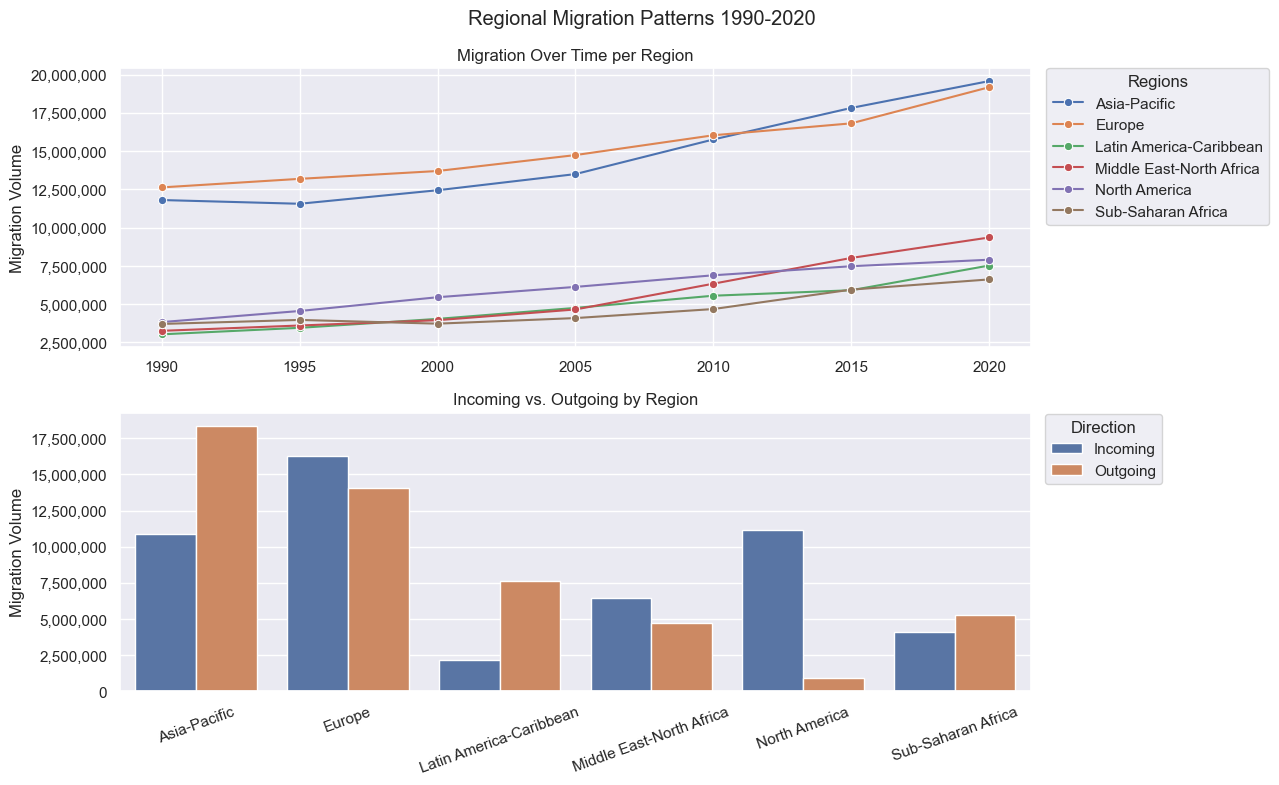

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8))  # Make figure wider
plt.subplots_adjust(right=0.85)  # Leave room for legend

sns.lineplot(data=region_level_df, 
             x='year', y='count', 
             hue='region', errorbar=None, 
             marker='o', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Migration Volume')
ax1.set_title('Migration Over Time per Region')
format_numbers(ax1)
ax1.legend(title="Regions",loc='center', bbox_to_anchor=(1.14, 0.72))

sns.barplot(data=region_level_df, 
            x='region', y='count', 
            errorbar=None, hue='direction', 
            ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Migration Volume')
ax2.set_title('Incoming vs. Outgoing by Region')
format_numbers(ax2)
plt.xticks(rotation=20)
ax2.legend(title="Direction",loc='center', bbox_to_anchor=(1.08, .87))

plt.suptitle('Regional Migration Patterns 1990-2020')
plt.tight_layout()

Regional migration volumes increased consistently across all regions from 1990 to 2020, though with distinct patterns. Europe initially led in migration volume until 2010, when Asia-Pacific surpassed it, with both regions maintaining substantially higher volumes than other regions. The remaining regions formed a lower-volume cluster, growing from approximately 3 million in 1990 to between 6 and 9 million by 2020. Despite Asia-Pacific's high total volume, it predominantly represents outgoing migration, contrasting with Europe's tendency toward incoming migration. North America stands out for having the largest positive net migration and showing notably steady growth, even through the 2005 global migration acceleration point that marked significant changes in other regions.

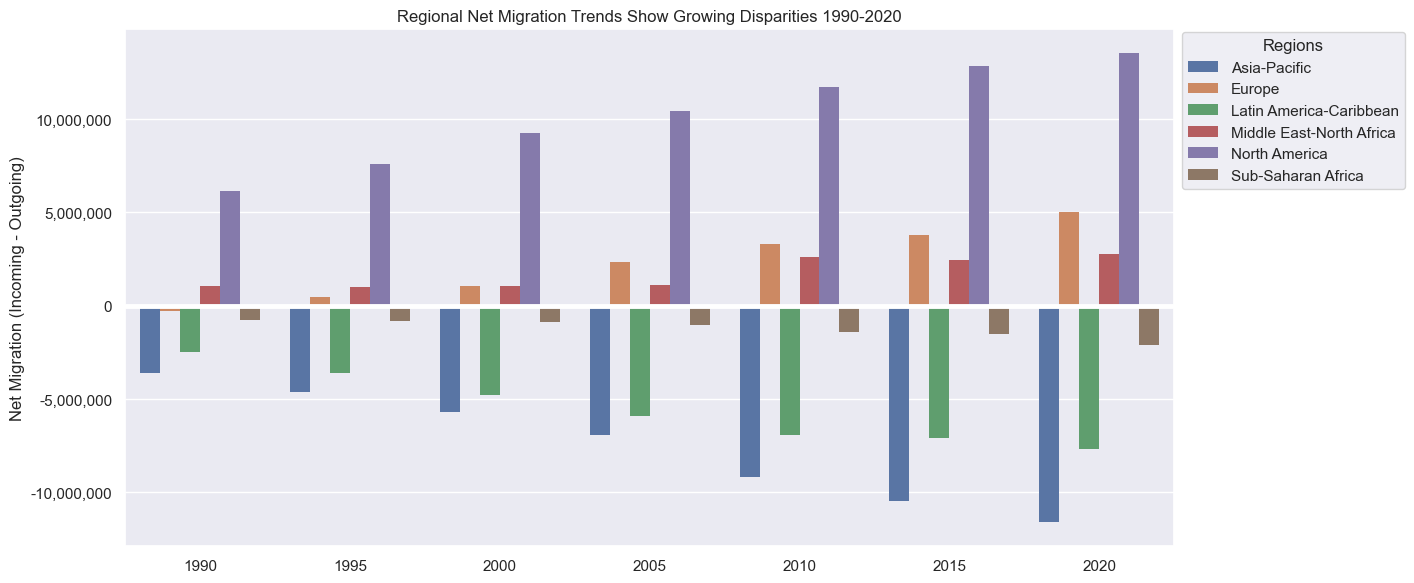

In [26]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(net_migration_df, 
                 x='year', 
                 y='net_migration', 
                 hue='region', linewidth=0)
format_numbers(ax)
plt.ylabel('Net Migration (Incoming - Outgoing)')
plt.xlabel('')
plt.title('Regional Net Migration Trends Show Growing Disparities 1990-2020')

plt.axhline(y=0, color='white', linestyle='-', linewidth=3.5)

plt.tight_layout()
plt.legend(title="Regions", bbox_to_anchor=(1, 1.01));

With a more detailed examination of regional net migration patterns, the disparity between North America and Asia-Pacific becomes more pronounced. North America has consistently been the largest net receiver of migrants, with positive net migration growing from 6 million to over 13 million during the study period. In contrast, Asia-Pacific and Latin America-Caribbean have emerged as major sending regions, with Asia-Pacific experiencing particularly significant net losses increasing from 3.6 million to approximately 12 million. Europe and the Middle East-North Africa regions have maintained relatively modest and stable positive net migration, while Sub-Saharan Africa has shown persistent but comparatively small net losses, totaling approximately 1.3 million.

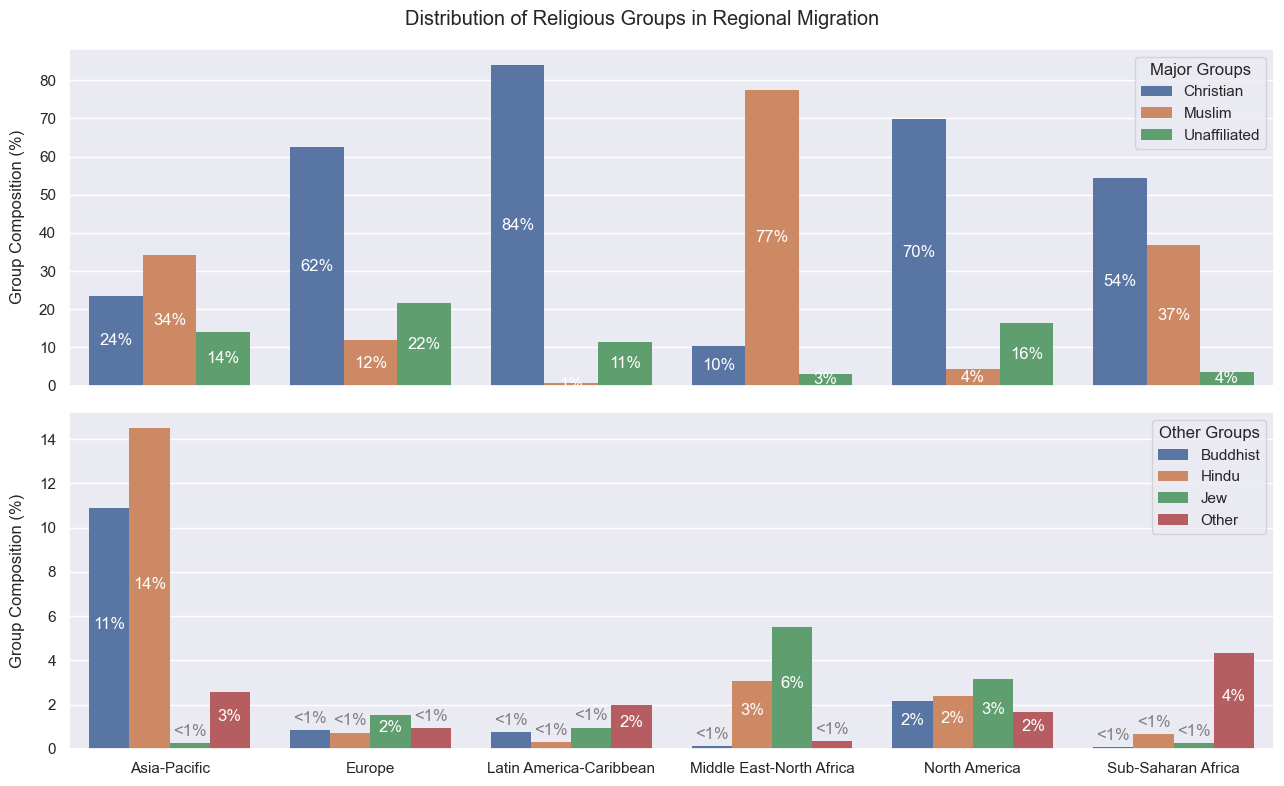

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

sns.barplot(data=major_religions_regions_pivoted, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0,
                   ax=ax1)

for container in ax1.containers:
    ax1.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')
    
format_numbers(ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Group Composition (%)', labelpad=10)
ax1.legend(title='Major Groups')


sns.barplot(data=other_religions_regions_pivoted, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0, ax=ax2)


for container in ax2.containers:
    # Handle values >= 1%
    ax2.bar_label(container, label_type='center', color='white',
                fmt=lambda x: f'{x:.0f}%' if x > 1 else '', 
                padding=3)
    # Handle values < 1%
    ax2.bar_label(container, label_type='edge', color='gray',
                fmt=lambda x: '<1%' if x <= 1 else '', 
                padding=3)
    
format_numbers(ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Group Composition (%)', labelpad=10)
ax2.legend(title='Other Groups')

plt.suptitle('Distribution of Religious Groups in Regional Migration')
plt.tight_layout()

Furthermore, regional migration patterns show distinct religious compositions. Due to the large differences in composition, the religions are split into two groups. In the major groups, Christians dominate most regions except Middle East/North Africa, where Muslims represent the majority. Among smaller religious groups, Asia-Pacific shows the highest diversity with notable Buddhist and Hindu populations. Jewish migration is most prominent in Middle East/North Africa, while other regions show relatively small percentages of minor religious groups.

# Country Breakdown

### Prep for Country Breakdown

In [32]:
country_level_df = migration[(migration['level'] == 1) & (migration['religion'] != 'All')].copy() # Creating country-level copy of original dataframe, filtering out 'All' religion value for cleaner approach
country_level_df['religion'] = country_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts


# Top 10 Countries by Total Global Migration
country_direction_totals = country_level_df.pivot_table(
    index='country', 
    columns='direction',
    values='count',
    aggfunc='sum')

country_direction_totals['Total'] = country_direction_totals['Incoming'] + country_direction_totals['Outgoing'] # Adding Totals column
top_10_totals = country_direction_totals.sort_values('Total', ascending=False).head(10) # Storing top 10 countries with largest migration volume

# Top 10 Countries Incoming vs Outgoing Migration
top_10_direction_comparison = top_10_totals.reset_index().melt(id_vars='country', 
            value_vars=['Incoming', 'Outgoing'], 
            var_name='direction', 
            value_name='Total Migration Volume' )

# Migration Trends by Top 10 Countries
high_vol_countries = ['United States', 'Russia', 'India','Germany'] #store high migration countries 
high_vol = country_level_df[country_level_df['country'].isin(high_vol_countries)] #filter country level dataframe for high volume countries
high_vol_trends = high_vol.pivot_table(index='year', columns='country', values='count', aggfunc='sum')

low_vol_countries = ['Ukraine', 'Mexico', 'United Kingdom', 'France', 'China', 'Pakistan'] #store low migration countries
low_vol = country_level_df[country_level_df['country'].isin(low_vol_countries)] #filter country level dataframe for low volume countries
low_vol_trends = low_vol.pivot_table(index='year', columns='country', values='count', aggfunc='sum')

# Religious Composition of Highest Migration Countries
top10_df = country_level_df[country_level_df['country'].isin(top_10_totals.index.tolist())]
country_religion_composition = top10_df.pivot_table(index=['country', 'religion'], values='percent').reset_index()

europe = ['France', 'Germany', 'Russia', 'Ukraine', 'United Kingdom']
north_america_latin = ['United States', 'Mexico']
asia_pacific = ['China', 'India', 'Pakistan']

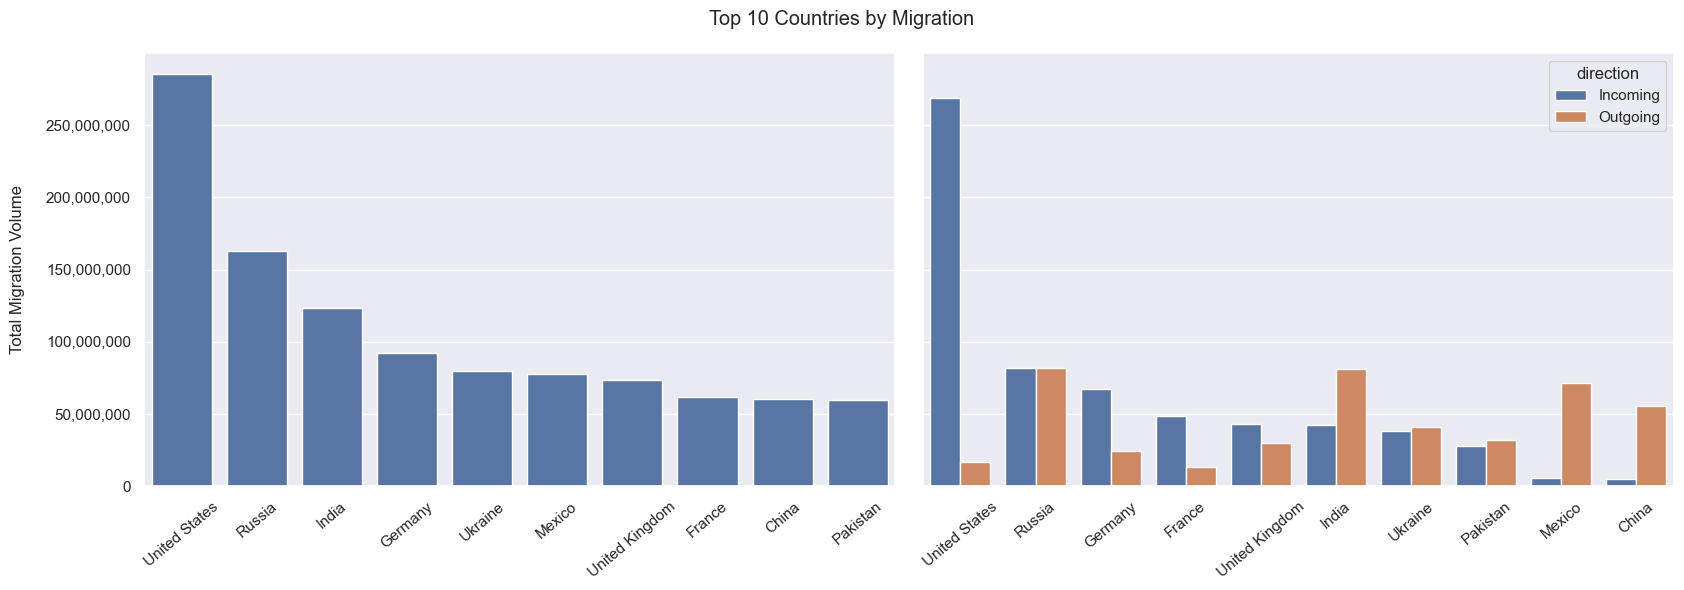

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

sns.barplot(data=top_10_totals, 
            x='country', 
            y='Total', 
            ax=ax1)

format_numbers(ax1)
ax1.tick_params(axis='x', rotation=40)
ax1.set_xlabel('')
ax1.set_ylabel('Total Migration Volume', labelpad=15)

# ---ax2
order = top_10_direction_comparison[top_10_direction_comparison['direction'] == 'Incoming'].sort_values('Total Migration Volume', ascending=False)['country']

sns.barplot(top_10_direction_comparison,
            x='country', 
            y='Total Migration Volume', 
            hue='direction', ax=ax2, 
            order=order)

format_numbers(ax2)
ax2.tick_params(axis='x', rotation=40)
ax2.set_xlabel('')

plt.suptitle('Top 10 Countries by Migration')
plt.tight_layout()

Analysis of the top 10 countries by migration volume reveals patterns that help explain the regional trends identified earlier. The United States dominates global migration with approximately 285 million total migrants, predominantly incoming (268.8M incoming vs 16.8M outgoing), which explains North America's position as the largest net receiver of migrants. Russia, ranking second with 163 million total migrants, shows a uniquely balanced migration pattern with nearly equal incoming and outgoing flows (81.5M each), contributing to Europe's relatively stable migration balance.

In the Asia-Pacific region, the world's two most populous countries show distinctive patterns. Despite their large populations, both India (123.4M total) and China (60M total) show lower overall migration volumes than the US, but are characterized by strong outward flows. India's 80.9M outgoing versus 42.5M incoming migrants, and China's even more pronounced 55.3M outgoing versus 4.9M incoming migrants, are the primary drivers of Asia-Pacific's substantial negative net migration.

The Latin America-Caribbean region's outward migration patterns are significantly influenced by Mexico, which shows heavily skewed patterns with 71.7M outgoing versus 5.7M incoming migrants. (Note: While geographically part of North America, Mexico is categorized as Latin America-Caribbean in this study, further emphasizing the United States' outsized role in North American migration patterns).

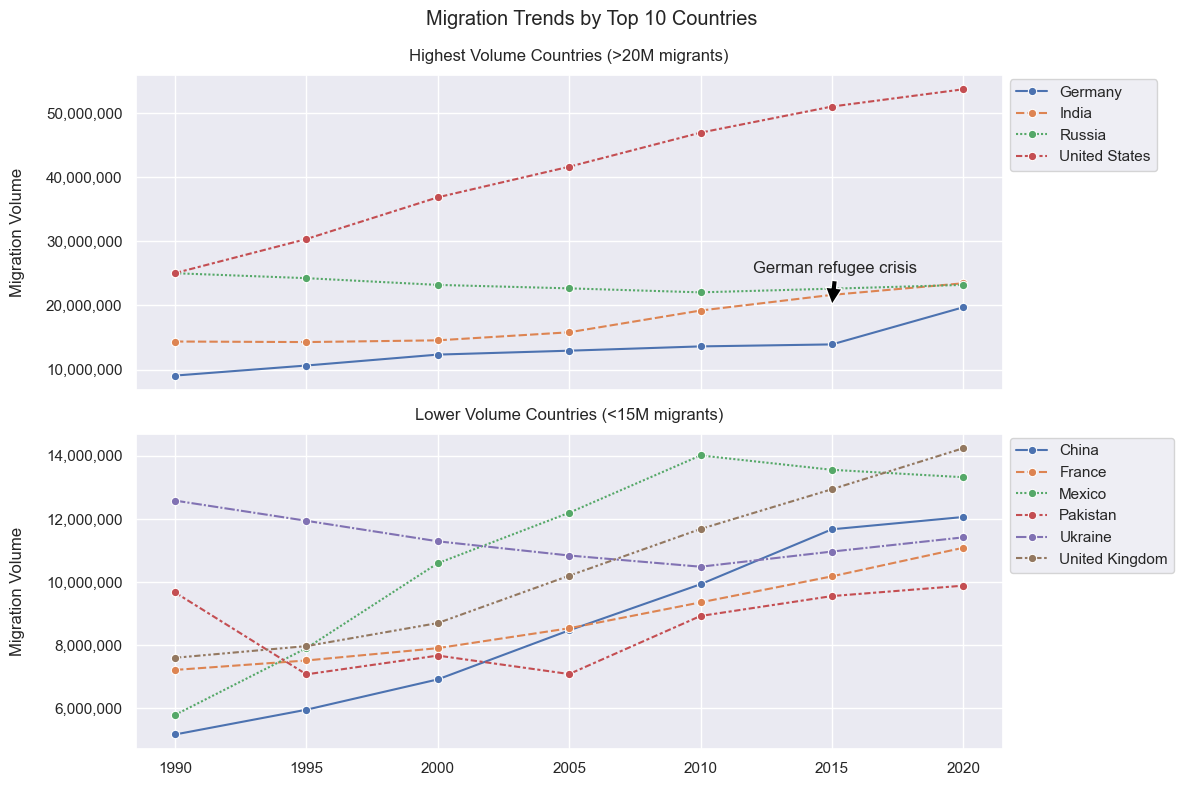

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sns.lineplot(high_vol_trends, marker='o', ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('Migration Volume', labelpad=15)
ax1.legend(title="", bbox_to_anchor=(1, 1.01))
ax1.set_title('Highest Volume Countries (>20M migrants)', pad=10)

ax1.annotate('German refugee crisis', 
           xy=(2015, 20000000),  # point to annotate
           xytext=(2012, 25000000),  # text position
           arrowprops=dict(facecolor='black', shrink=0.03))


sns.lineplot(low_vol_trends, marker='o', ax=ax2)
format_numbers(ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Migration Volume', labelpad=15)
ax2.legend(title="", bbox_to_anchor=(1, 1.01))
ax2.set_title('Lower Volume Countries (<15M migrants)', pad=10)

plt.suptitle('Migration Trends by Top 10 Countries')
plt.tight_layout()

Analysis of migration trends among the top 10 countries from 1990-2020 reveals several significant patterns. The United States maintained substantial dominance in migration volume, showing sharp growth through 2000 before transitioning to more moderate increases. Russia's trajectory provides a striking contrast, declining from initially high levels before stabilizing around 2010. India emerged as a major source of outbound migration, with significant growth post-2005, while Germany's most notable feature is a dramatic increase after 2015, coinciding with the European migration crisis.

Among countries with lower migration volumes, Mexico stands out with the most consistent upward trajectory, while Ukraine's pattern of decline and subsequent reversal after 2010 represents the most dramatic shift in trend.

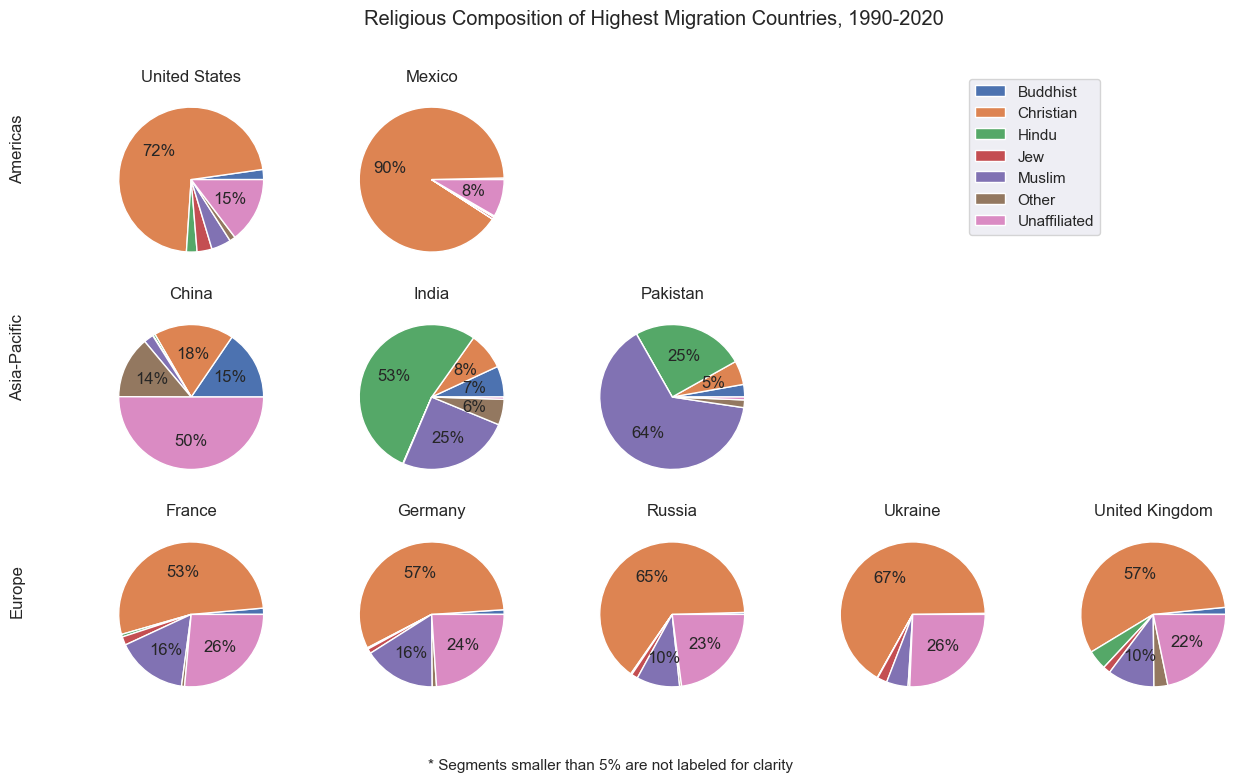

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 5, figsize=(15, 8))

# For North America/Latin Caribbean (first row)
for i, country in enumerate(north_america_latin):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax1[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']))
    ax1[i].set_title(country)

# For Asia Pacific (second row)
for i, country in enumerate(asia_pacific):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax2[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']))
    ax2[i].set_title(country)

# For Europe (third row)
for i, country in enumerate(europe):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax3[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']))
    ax3[i].set_title(country) 


ax1[0].text(-.5, 0.5, 'Americas', rotation=90, transform=ax1[0].transAxes)
ax2[0].text(-.5, 0.5, 'Asia-Pacific', rotation=90, transform=ax2[0].transAxes)
ax3[0].text(-.5, 0.5, 'Europe', rotation=90, transform=ax3[0].transAxes)

# Removing unused subplots
plt.delaxes(ax2[3])
plt.delaxes(ax2[4])
plt.delaxes(ax1[2])
plt.delaxes(ax1[3])
plt.delaxes(ax1[4])

fig.text(x=0.35, y=0.03, s='* Segments smaller than 5% are not labeled for clarity', size=11)
plt.suptitle('Religious Composition of Highest Migration Countries, 1990-2020')
plt.legend(bbox_to_anchor=(0.25, 3.5));

Analysis of religious composition among the top migration countries reveals distinct regional and country-specific patterns from 1990-2020. The Americas show predominantly Christian migration, with Mexico at 90% and the US at 72%. European countries display consistent religious patterns with Christian majorities (53-67%) and notable Muslim and Unaffiliated populations. The Asia-Pacific region shows the most diversity: China stands out with 50% Unaffiliated migrants, while India and Pakistan show complementary patterns with Hindu (53%) and Muslim (64%) majorities respectively, each maintaining significant minorities of the other religion (25% each).

In [39]:
#Composition over time
religions = ['Buddhist', 'Christian', 'Hindu', 'Jew', 'Muslim', 'Other', 'Unaffiliated']
area_plot_df = top10_df.pivot_table(
    index=['country', 'year'],
    columns='religion',
    values='percent'
).reset_index()
area_plot_df

religion,country,year,Buddhist,Christian,Hindu,Jew,Muslim,Other,Unaffiliated
0,China,1990,17.95,14.00,0.30,0.05,1.30,19.80,46.65
1,China,1995,16.75,15.90,0.50,0.05,1.80,17.70,47.25
2,China,2000,15.45,17.90,0.55,0.05,2.20,16.20,47.70
3,China,2005,14.90,18.75,0.50,0.10,2.35,13.05,50.35
4,China,2010,14.70,19.00,0.55,0.10,2.40,10.85,52.45
...,...,...,...,...,...,...,...,...,...
65,United States,2000,2.30,71.80,2.10,3.50,4.05,1.30,14.95
66,United States,2005,2.25,72.40,2.25,3.30,4.10,1.25,14.45
67,United States,2010,2.15,73.05,2.35,3.10,4.10,1.25,13.95
68,United States,2015,2.25,71.45,2.75,3.05,4.95,1.35,14.25


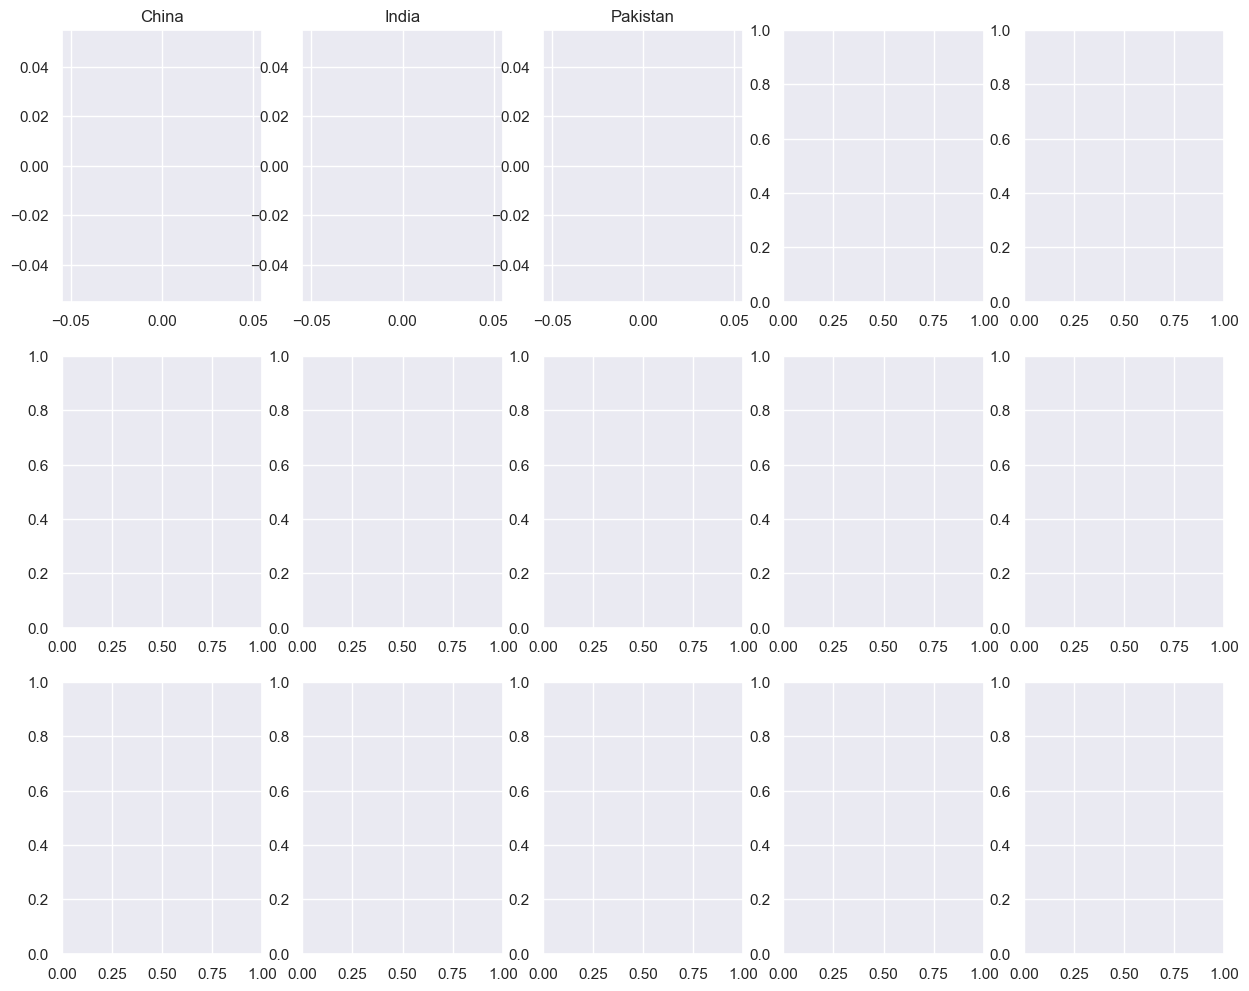

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 5, figsize=(15, 12))  # 3 rows, 5 columns

for i, country in enumerate(asia_pacific):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    #ax1[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']))
    ax1[i].plot(kind='line', data=country_data)
    ax1[i].set_title(country)

In [41]:
country_data = area_plot_df[area_plot_df['country'] == 'India']
country_data

religion,country,year,Buddhist,Christian,Hindu,Jew,Muslim,Other,Unaffiliated
21,India,1990,6.85,7.15,55.15,0.15,25.20,5.15,0.35
22,India,1995,7.15,7.20,54.90,0.15,24.65,5.50,0.40
23,India,2000,7.05,7.35,54.70,0.15,24.50,5.80,0.45
24,India,2005,6.90,8.15,53.70,0.10,24.50,6.10,0.55
25,India,2010,6.70,9.25,51.95,0.10,25.65,5.75,0.60
26,India,2015,6.80,9.45,51.40,0.10,25.80,5.85,0.60
27,India,2020,6.85,9.55,51.20,0.05,25.80,5.90,0.60
